# Beers

### Dependencies

In [3]:
# Dependencies and Setup
import warnings
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests as req
import time
import scipy.stats as st
from datetime import datetime
from scipy.stats import linregress
from pathlib import Path

# Import the OpenWeatherMap API key
from api_keys_JT import weather_api_key as weather_key
# Import geoapify API key
from api_keys_JT import geoapify_key as geo_key
# Import Census Data API key
from api_keys_JT import census_api_key as census_key

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)




# Yearly US Beer Consumption On Premise Use
## 2019 - 2023
---
    Beer consumption in the US peaked in 2022.
    The state with the largest consumption was California.
    The state with the least consumption was New Hampshire.
---

In [192]:
# Read CSV excise tax File
Excise_Tax_file = Path("niaaa Data/excise_tax.csv")
Excise_Tax_file_df = pd.read_csv(Excise_Tax_file)
Excise_Tax_file_df.head()

,Jurisdiction,Excise Tax Per Gallon
0,Alabama,1.05
1,Alaska,1.07
2,Arizona,0.16
3,Arkansas,0.24
4,California,0.20


In [7]:
# Read CSV Population File
State_Population_Report_file = Path("Population Data/Cencus.csv")
State_Population_Report_df = pd.read_csv(State_Population_Report_file)
State_Population_Report_df.head()

,State,2020,2021,2022,2023
0,Alabama,5031864,5050380,5073903,5108468
1,Alaska,732964,734923,733276,733406
2,Arizona,7186683,7272487,7365684,7431344
3,Arkansas,3014348,3028443,3046404,3067732
4,California,39503200,39145060,39040616,38965193


In [161]:
# Read CSV Production File
State_Production_Report_file = Path("TTB_Quarterly_Rpt/State_Beer_Report_2019-2023.csv")
State_Production_Report_df = pd.read_csv(State_Production_Report_file)

top_ten_states = State_Production_Report_df.groupby(['STATE'])['Sum of Tax-Determined,\nPremises Use'].sum()
State_Production_grouped_df = top_ten_states.reset_index()
top_ten_states = top_ten_states.sort_values(ascending=False)
bottom_ten_states = pd.DataFrame(top_ten_states.sort_values(ascending=True))
top_ten_states = pd.DataFrame(top_ten_states.head(10).reset_index())

bottom_ten_states.head()

,"Sum of Tax-Determined,\nPremises Use"
STATE,
District of\nColumbia,4514.76
New\nHampshire,35848.09
Mississippi,38609.97
West Virginia,41079.01
Hawaii,51038.24


In [205]:
popspan_2020_2023_df = pd.DataFrame({'State':[],'Population 2020 to 2023':[], 'Gallons Consumed Per Capita':[], 'Tax Per Gallon':[]})

for state in State_Population_Report_df['State']:
    pop_2020 = pd.DataFrame(State_Population_Report_df.loc[(State_Population_Report_df['State'] == state), ['2020']]).sum()
    pop_2021 = pd.DataFrame(State_Population_Report_df.loc[(State_Population_Report_df['State'] == state), ['2021']]).sum()
    pop_2022 = pd.DataFrame(State_Population_Report_df.loc[(State_Population_Report_df['State'] == state), ['2022']]).sum()
    pop_2023 = pd.DataFrame(State_Population_Report_df.loc[(State_Population_Report_df['State'] == state), ['2023']]).sum()

    pop_2020 = pop_2020.sum()
    pop_2021 = pop_2021.sum()
    pop_2022 = pop_2022.sum()
    pop_2023 = pop_2023.sum()

    tax_per_gallon = Excise_Tax_file_df.loc[(Excise_Tax_file_df['Jurisdiction'] == state)]['Excise Tax Per Gallon']
    tax_per_gallon = tax_per_gallon.sum()

    tax_sum = State_Production_grouped_df.loc[(State_Production_grouped_df['STATE'] == state)]['Sum of Tax-Determined,\nPremises Use']
    tax_sum = tax_sum.sum()
    consume_capita = (pop_2020 + pop_2021 + pop_2022 + pop_2023) / (tax_sum)
    consume_capita = consume_capita * tax_per_gallon

    
    popspan_2020_2023_df.loc[len(popspan_2020_2023_df)] = {'State':state, 
                                                           'Population 2020 to 2023':pop_2020 + pop_2021 + pop_2022 + pop_2023,
                                                           'Gallons Consumed Per Capita':consume_capita,
                                                           'Tax Per Gallon':tax_per_gallon}
    

# top_ten_states = top_ten_states.sort_values(ascending=False)
popspan_2020_2023_df = popspan_2020_2023_df.sort_values(by=['Gallons Consumed Per Capita'], ascending=False)
popspan_top_ten_2020_2023_df = pd.DataFrame(popspan_2020_2023_df.head(10).reset_index())
popspan_top_ten_2020_2023_df

C:\Users\scorp\AppData\Local\Temp\ipykernel_91988\1467802136.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  consume_capita = (pop_2020 + pop_2021 + pop_2022 + pop_2023) / (tax_sum)
C:\Users\scorp\AppData\Local\Temp\ipykernel_91988\1467802136.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  consume_capita = consume_capita * tax_per_gallon


,index,State,Population 2020 to 2023,Gallons Consumed Per Capita,Tax Per Gallon
0,24,Mississippi,11786609,131.267698,0.43
1,0,Alabama,20264615,105.347636,1.05
2,11,Hawaii,5772463,105.183693,0.93
3,42,Tennessee,28065265,96.351190,1.29
4,10,Georgia,43465152,92.219265,1.01
5,40,South Carolina,20982509,60.269346,0.77
6,9,Florida,88278254,48.015383,0.48
7,36,Oklahoma,16029963,41.378811,0.40
8,47,Washington,31063356,34.948202,0.76
9,44,Utah,13422236,32.765781,0.42


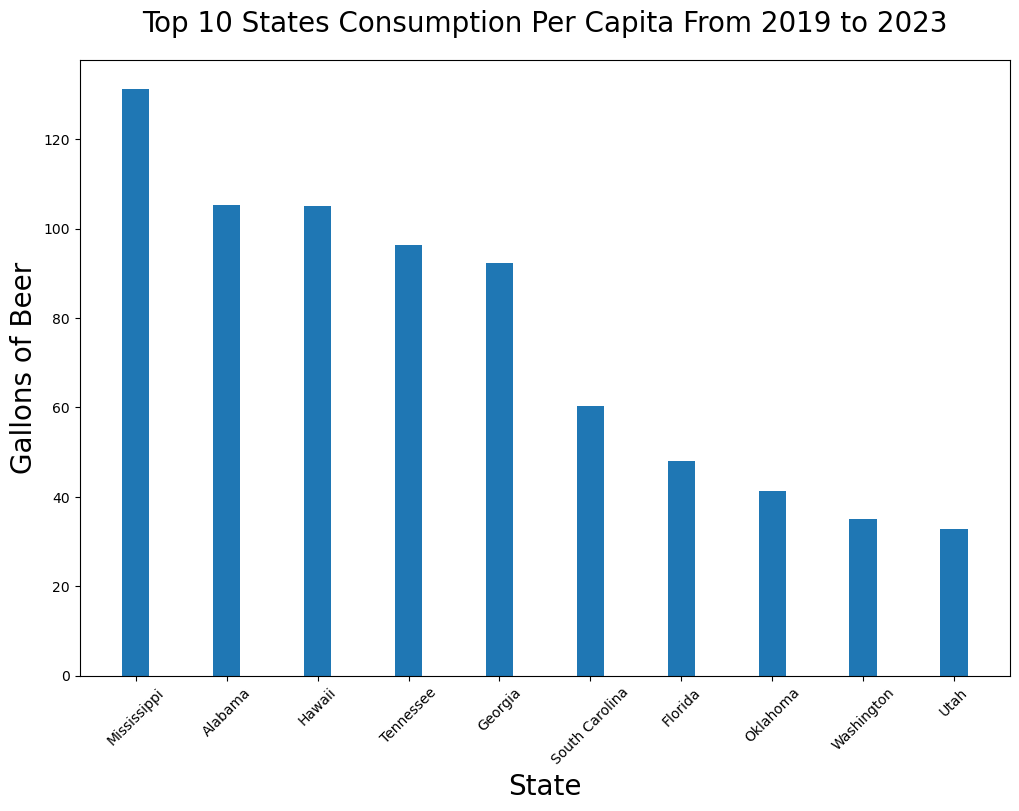

In [207]:
# Plot stacked bar by state

plt.figure(figsize=(12, 8))
plt.bar(popspan_top_ten_2020_2023_df['State'], popspan_top_ten_2020_2023_df['Gallons Consumed Per Capita'], width=0.3)
plt.title("Top 10 States Consumption Per Capita From 2019 to 2023", fontsize = 20, pad=20)
plt.xlabel("State", fontsize = 20)
plt.ylabel("Gallons of Beer", fontsize = 20) 
plt.xticks(rotation=45)

# Save the figure
plt.savefig("Beers_location_Final_Outputs/Top_10_States_Consumption.png")

plt.show()

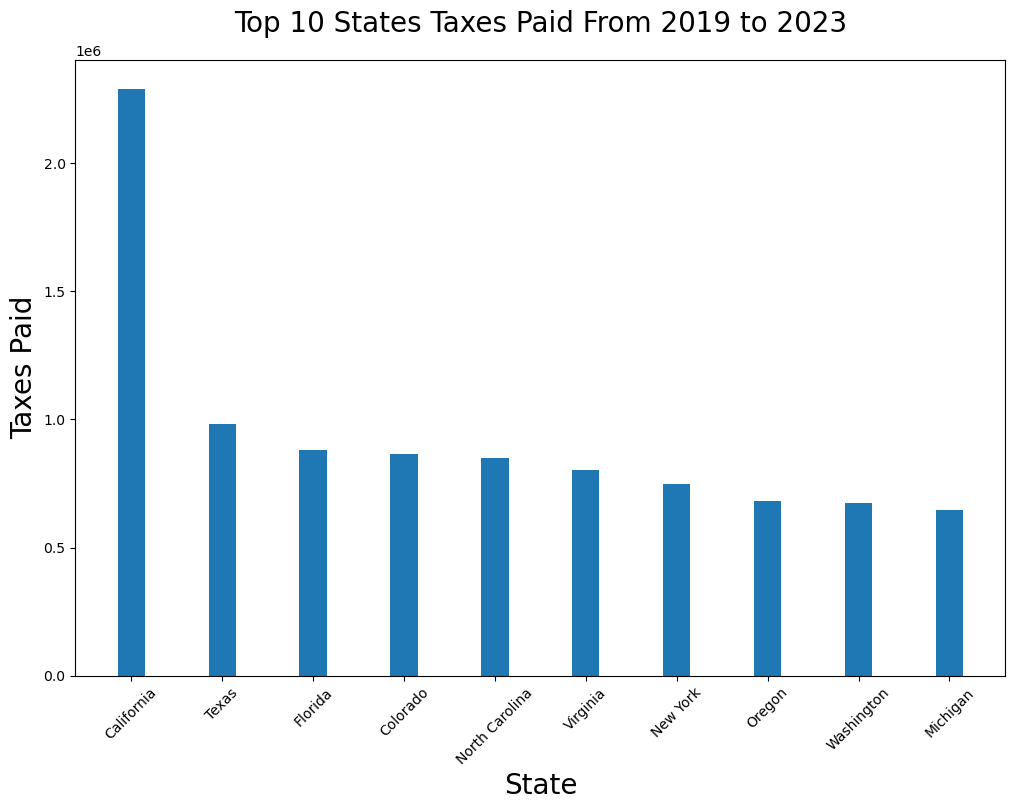

In [208]:
# Plot stacked bar by state

plt.figure(figsize=(12, 8))
plt.bar(top_ten_states['STATE'], top_ten_states['Sum of Tax-Determined,\nPremises Use'], width=0.3)
plt.title("Top 10 States Taxes Paid From 2019 to 2023", fontsize = 20, pad=20)
plt.xlabel("State", fontsize = 20)
plt.ylabel("Taxes Paid", fontsize = 20) 
plt.xticks(rotation=45)

# Save the figure
plt.savefig("Beers_location_Final_Outputs/Top_10_States_Consumption.png")

plt.show()

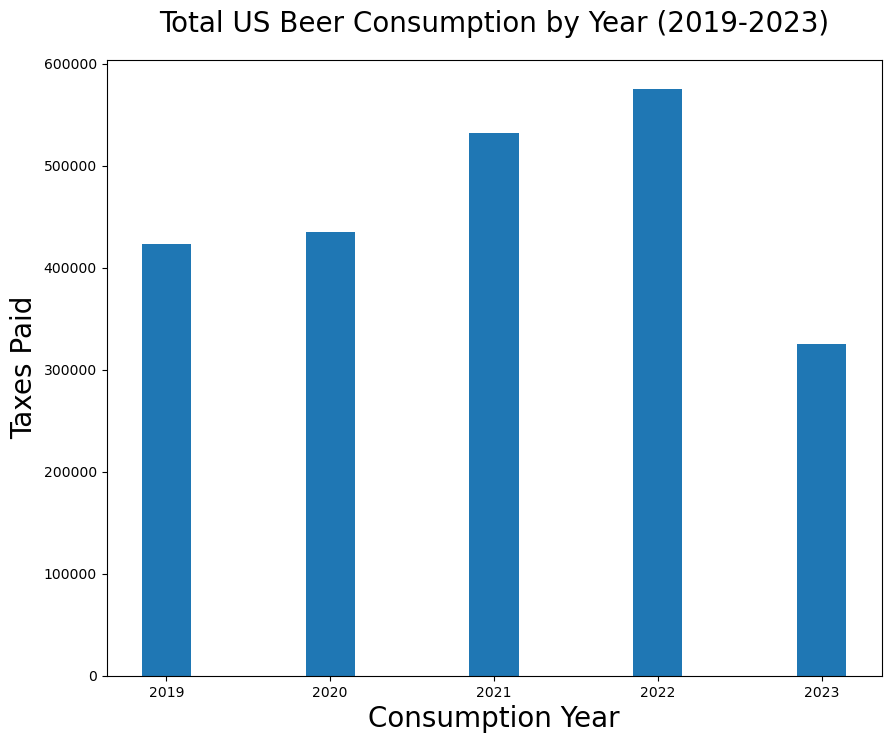

In [4]:
# Plot total all statea

plt.figure(figsize=(10, 8))

plt.bar(State_Production_Report_df['Year'], State_Production_Report_df['Sum of Tax-Determined,\nPremises Use'], width=0.3)  
plt.title("Total US Beer Consumption by Year (2019-2023)", fontsize = 20, pad=20)
plt.xlabel("Consumption Year", fontsize = 20)
plt.ylabel("Taxes Paid", fontsize = 20) 

# Save the figure
plt.savefig("Beers_location_Final_Outputs/Total_US_Beer_Consumption.png")

plt.show()

# Sample DataFrame of breweries per state

## Create DataFrame for https://api.openbrewerydb.org/v1/breweries

In [5]:
beer_info_df = pd.DataFrame({'id':[],'name':[],'brewery_type':[],'address_1':[],'address_2':[],'address_3':[],
                             'city':[],'state_province':[],'postal_code':[],'country':[],'longitude':[],'latitude':[],
                             'phone':[],'website_url':[],'state':[],'street':[]})

In [6]:
try:
    page_count = int(9000 / 200)
    # page_count = 5 #testing
    for i in range(page_count):
        time.sleep(.5)
        path = f"https://api.openbrewerydb.org/v1/breweries?per_page=200&page={str(i)}"
        # print(req)
        beer_info = req.get(path).json()
        beer_info = pd.DataFrame(beer_info)
        beer_info_df = pd.concat([beer_info_df, beer_info], ignore_index=True)
except:
    print(f'Stopped at {i} pages')

In [7]:
beer_info_df.sample()

,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street
7151,b2f096d6-1297-43d7-bf20-429cbbc3ddf7,Strawn Brewing Co,micro,27 Word St,None,None,Fairburn,Georgia,30213-1545,United States,-84.58368873,33.56062198,6785453775,http://www.strawnbrewing.com,Georgia,27 Word St


In [8]:
# delete duplicates
dup_data = beer_info_df[['id']]
dup_data_beer_info = dup_data[dup_data.duplicated()]['id'].unique()

In [9]:
beer_info_df = beer_info_df.set_index('id').drop(dup_data_beer_info).reset_index()
beer_info_df.sort_values(by=['country']).sample()

,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street
1729,260ec59d-2c3d-4fb1-957b-ec0a6d2cee5a,Coney Island Beer,micro,1904 Surf Ave,None,None,Brooklyn,New York,11224-2410,United States,-73.98572367,40.57502661,8184518452,http://www.coneyislandbeer.com,New York,1904 Surf Ave


In [10]:
all_US_Brew_Count = beer_info_df.loc[beer_info_df['country'] == 'United States']['longitude']
all_US_Brew_Count.count()

5515

# Breweries Types - Contract and Planning
---
    There are 59 breweries in planning
        - The majority of planned breweries are on the west coast.
        - This suggests that west coast has a higher rate of entrepreneurship in the brewery industry.

    There are 98 breweries in contract
        - These types of breweries are spread throughout the midwest and coast lines
        - Dry states such as Arizona have only few or no contract breweries.
            * Possibly due to climate conditions.
---

In [11]:
state_breweries = beer_info_df.loc[beer_info_df['country'] == 'United States']
state_brewery_types =  state_breweries.groupby(['state_province', 'brewery_type']).count().reset_index()
state_brewery_types = state_brewery_types[['state_province', 'brewery_type','id']]
state_brewery_types = state_brewery_types.rename(columns={"id": "count"})

## US Brewies in Planning

### Code

In [12]:
# Filter 
map_points_df = beer_info_df.loc[beer_info_df['country'] == 'United States']
map_points_df = map_points_df.loc[beer_info_df['brewery_type'] == 'planning']

# Grab the columns used for the map
map_points_df = map_points_df[['longitude','latitude','name','brewery_type','city', 'state', 'website_url']].copy()

# Drop useless data
map_points_df = map_points_df.mask(map_points_df.eq('None')).dropna()

# Convert Lat Lon to numbers
map_points_df['longitude'] = pd.to_numeric(map_points_df['longitude'])
map_points_df['latitude'] = pd.to_numeric(map_points_df['latitude'])

# Set Map Plot
brewery_map_plot = map_points_df.hvplot.points(
    "longitude",
    "latitude",
    hover_cols = ['name', 'brewery_type', 'state', 'website_url'],
    geo = True,
    tiles = "OSM",
    frame_width = 600,
    frame_height = 500,
    size = 50,
    scale = 2.0,
    color = "city",
    fill_alpha = .5
)

C:\Users\scorp\anaconda3\envs\dev\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [13]:
count = map_points_df['name'].count()
print(f"Number of US Breweries in planning = {count}")

Number of US Breweries in planning = 59


### Display Planning Breweries Map

In [14]:
# Save the figure
hvplot.save(brewery_map_plot, 'Beers_location_Final_Outputs/Planned_Breweries.html')

# Display Map Plot
brewery_map_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (city,name,brewery_type,state,website_url)

## US Contract Breweries

### Code

In [15]:
# Filter 
map_points_df = beer_info_df.loc[beer_info_df['country'] == 'United States']
map_points_df = map_points_df.loc[beer_info_df['brewery_type'] == 'contract']

# Grab the columns used for the map
map_points_df = map_points_df[['longitude','latitude','name','brewery_type','city', 'state', 'website_url']].copy()

# Drop useless data
map_points_df = map_points_df.mask(map_points_df.eq('None')).dropna()

# Convert Lat Lon to numbers
map_points_df['longitude'] = pd.to_numeric(map_points_df['longitude'])
map_points_df['latitude'] = pd.to_numeric(map_points_df['latitude'])

# Set Map Plot
brewery_map_plot = map_points_df.hvplot.points(
    "longitude",
    "latitude",
    hover_cols = ['name', 'state', 'website_url'],
    geo = True,
    tiles = "OSM",
    frame_width = 600,
    frame_height = 500,
    size = 50,
    scale = 2.0,
    color = "city",
    fill_alpha = .5
)


In [16]:
count = map_points_df['name'].count()
print(f"Number of US Breweries in contract = {count}")

Number of US Breweries in contract = 98


### Display Contract Breweries Map

In [17]:
# Save the figure
hvplot.save(brewery_map_plot, 'Beers_location_Final_Outputs/Contract_Breweries.html')

# Display Map Plot
brewery_map_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (city,name,state,website_url)

# Number of US Brewery Types
---
    There are 7 brewery types in the US with an addition type listed as closed.
    The most common brewery is the micro brewery.
---

### Code

In [18]:
state = state_brewery_types['state_province']
all_brewtypes = state_brewery_types.groupby(['state_province'])['count'].sum()
brew_type = state_brewery_types['brewery_type']
count = state_brewery_types['count']
all_brewtypes = all_brewtypes.sort_values(ascending=False)

In [19]:
# Unique Brewery Names
brew_type_names = brew_type.unique()

# Get Sum of Brewery Types
brew_type_counts = []
state_brewery_types_indexed = state_brewery_types.set_index('brewery_type')
for i in brew_type_names:
    brew_type_counts = state_brewery_types_indexed.groupby('brewery_type')['count'].sum()


# Prep Data for Bar Chart
brew_type_counts = brew_type_counts[brew_type_counts > 50].sort_values(ascending=False)
# For X Labels
brew_type_names = brew_type_counts.reset_index()
brew_type_names = brew_type_names['brewery_type']

## List Brew Types

In [20]:
brew_type_names_df  = pd.DataFrame(brew_type_names)
brew_type_names_df

,brewery_type
0,micro
1,brewpub
2,planning
3,regional
4,contract
5,closed
6,large
7,proprietor


### Plot Brew Type Counts in the US

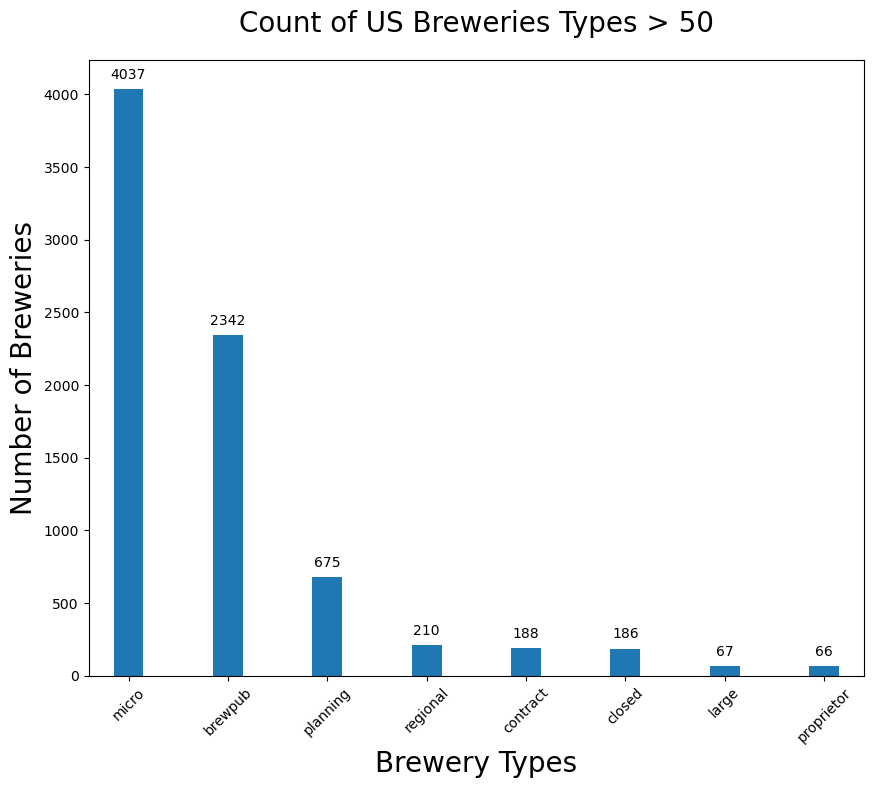

In [21]:
# Plot Brewtypes
plt.figure(figsize=(10, 8))
ax = brew_type_counts.plot(kind="bar", width=0.3)
ax.set_title("Count of US Breweries Types > 50", fontsize = 20, pad=20)
ax.set_xlabel("Brewery Types", fontsize = 20)
ax.set_ylabel("Number of Breweries", fontsize = 20)
ax.set_xticklabels(brew_type_names, rotation=45)

rects = ax.patches

# Create Number labels.
labels = [f"label{i}" for i in range(len(rects))]

for rect, label in zip(rects, brew_type_counts):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 50, label, ha="center", va="bottom"
    )

# Save the figure
plt.savefig("Beers_location_Final_Outputs/Count of US Breweries Types gt 50.png")

plt.show()

# Number of Breweries per State and Total
---
    The total number of breweries listed for the US is 5515.
    Per state, California has the largest amount of breweries.
    Mississippi has the least amount of breweries
    
    From the observations, we can say that California ranks number one in the US for both consumption and for breweries
---

In [22]:
print(f'The total number of breweries listed for the US is {all_US_Brew_Count.count()}')

The total number of breweries listed for the US is 5515


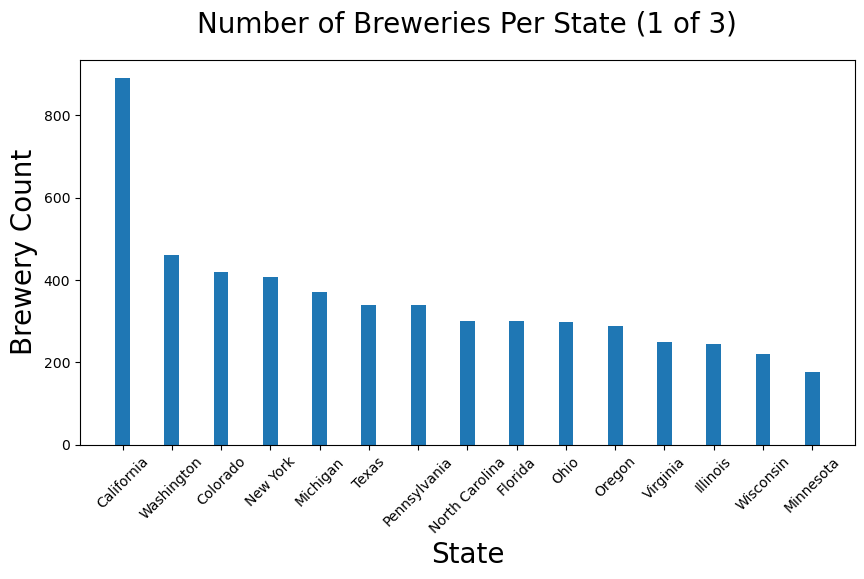

In [23]:
sub_set_of = pd.DataFrame(all_brewtypes.iloc[0:15]).reset_index()
sub_set_of

plt.figure(figsize=(10, 5))
plt.bar(sub_set_of['state_province'], sub_set_of['count'], width=0.3)
plt.title("Number of Breweries Per State (1 of 3)", fontsize = 20, pad=20)
plt.xlabel("State", fontsize = 20)
plt.ylabel("Brewery Count", fontsize = 20) 
plt.xticks(rotation=45)
   
# Save the figure
plt.savefig("Beers_location_Final_Outputs/Number of Breweries Per State (1 of 3).png")

plt.show()

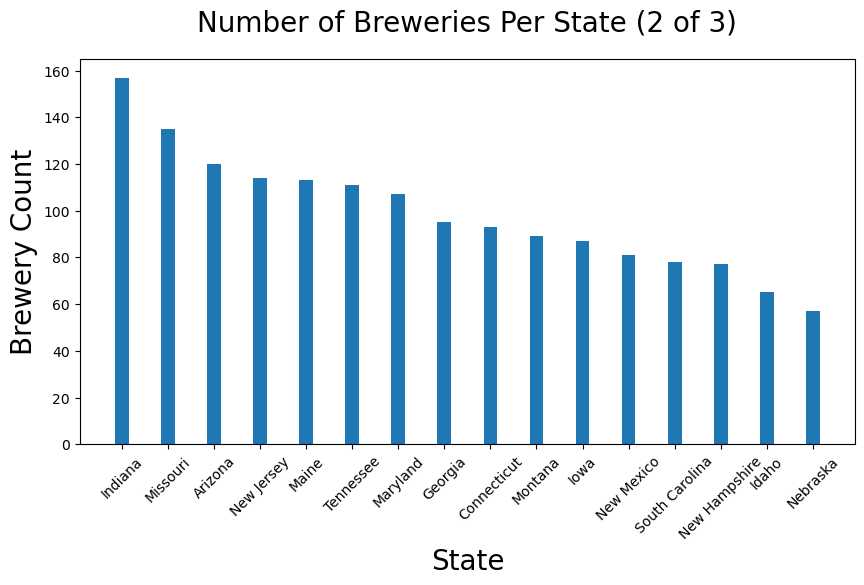

In [24]:
sub_set_of = pd.DataFrame(all_brewtypes.iloc[16:32]).reset_index()
sub_set_of

plt.figure(figsize=(10, 5))
plt.bar(sub_set_of['state_province'], sub_set_of['count'], width=0.3)
plt.title("Number of Breweries Per State (2 of 3)", fontsize = 20, pad=20)
plt.xlabel("State", fontsize = 20)
plt.ylabel("Brewery Count", fontsize = 20) 
plt.xticks(rotation=45)

# Save the figure
plt.savefig("Beers_location_Final_Outputs/Number of Breweries Per State (2 of 3).png")

plt.show()

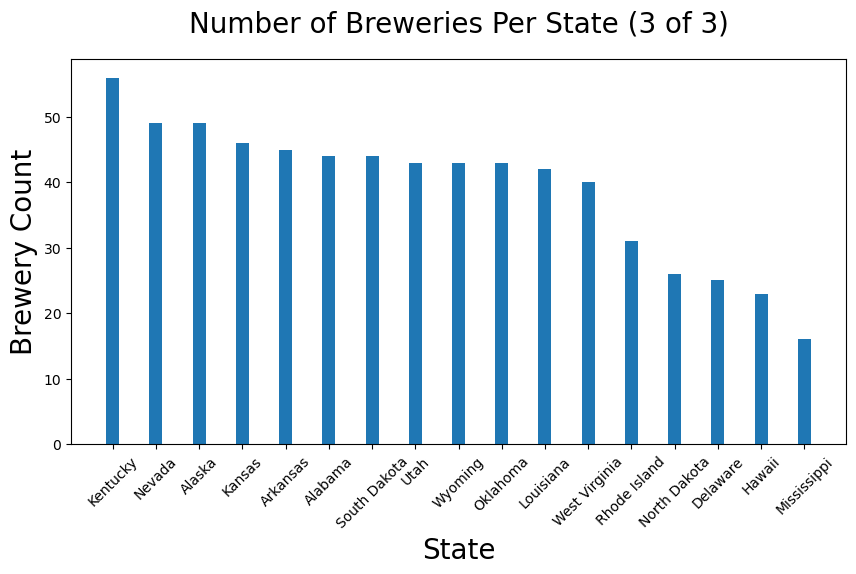

In [25]:
sub_set_of = pd.DataFrame(all_brewtypes.iloc[33:50]).reset_index()
plt.figure(figsize=(10, 5))
plt.bar(sub_set_of['state_province'], sub_set_of['count'], width=0.3)
plt.title("Number of Breweries Per State (3 of 3)", fontsize = 20, pad=20)
plt.xlabel("State", fontsize = 20)
plt.ylabel("Brewery Count", fontsize = 20) 
plt.xticks(rotation=45)

# Save the figure
plt.savefig("Beers_location_Final_Outputs/Number of Breweries Per State (3 of 3).png")

plt.show()